In [1]:
# https://twiecki.io/blog/2019/01/14/supply_chain/
# Bayesian thinking for supply chain optimization

import pymc3 as pm
import theano.tensor as tt
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [2]:
SUPPLIER_YIELD = np.array([.9, .5, .8]) # unknown
SUPPLIER_YIELD_SD = np.array([.1, .2, .2]) # unknown
PRICES = [220.0, 100.0, 120.0] # known
MAX_ORDER_SIZE = [100, 80, 100] # known

In [3]:
N_OBS = [30, 20, 2]

In [4]:
np.random.seed(100)
data = []
for supplier_yield, supplier_yield_sd, n_obs in zip(SUPPLIER_YIELD, SUPPLIER_YIELD_SD, N_OBS):
    data.append(pm.Beta.dist(mu=supplier_yield, sd=supplier_yield_sd, shape=n_obs).random())
    
data

[array([0.978235  , 0.98946102, 0.99035051, 0.83762708, 0.66130327,
        0.98785994, 0.85327018, 0.8500779 , 0.99913878, 0.89881072,
        0.8175994 , 0.95181804, 0.91545214, 0.87137954, 0.96166603,
        0.99033823, 0.96319861, 0.94124979, 0.96555922, 0.96606356,
        0.92723444, 0.97736913, 0.86764773, 0.81749131, 0.98597604,
        0.97980665, 0.77295709, 0.9584931 , 0.88875261, 0.99585613]),
 array([0.51788973, 0.67831661, 0.64888304, 0.61595363, 0.08634205,
        0.72543455, 0.51883833, 0.5454235 , 0.30357696, 0.21743938,
        0.54628383, 0.68559965, 0.28827533, 0.79246239, 0.65810975,
        0.69059483, 0.59297579, 0.85482231, 0.38115298, 0.8296909 ]),
 array([0.89241857, 0.9000698 ])]

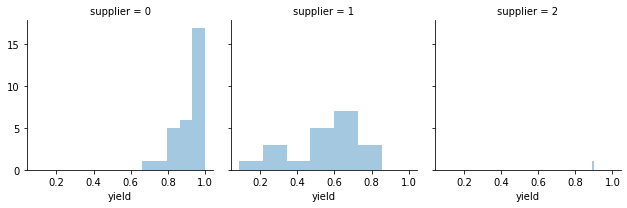

In [5]:
data_df = pd.DataFrame(data).T
data_tidy = data_df.unstack().to_frame('yield')
data_tidy.index = data_tidy.index.set_names(['supplier', 'obs'])
g = sns.FacetGrid(data=data_tidy.reset_index().dropna(), col='supplier')
g.map(sns.distplot, 'yield', kde=False);

## The dynamics of operating a Port

In [6]:
SALES_PRICE = 500 
HOLDING_COST = 100

In [7]:
@np.vectorize
def loss(in_stock, demand, buy_price, sales_price=SALES_PRICE, holding_cost=HOLDING_COST):
    # How much do we earn per launch
    margin = sales_price - buy_price
    # Do we have more in stock than demanded?
    if in_stock > demand:
        total_profit = demand * margin
        # everything left over after demand was met goes into holding
        total_holding_cost = (in_stock - demand) * holding_cost
        reward = total_profit - total_holding_cost
    else:
        # Can only sell what we have in stock, no storage required
        reward = in_stock * margin
    
    # Usually we minimize, so invert
    return -reward

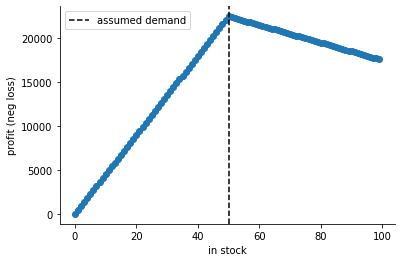

In [8]:
in_stock = np.arange(0, 100)
plt.scatter(in_stock, -loss(in_stock, 50, 50)); plt.axvline(50, c='k', ls='--', label='assumed demand');
plt.xlabel('in stock'); plt.ylabel('profit (neg loss)'); sns.despine(); plt.legend();

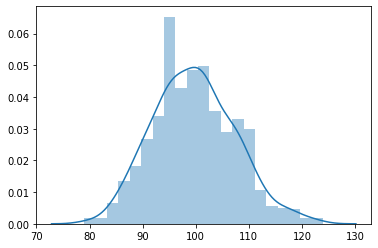

In [9]:
demand_samples = stats.poisson(60, 40).rvs(1000)
sns.distplot(demand_samples);

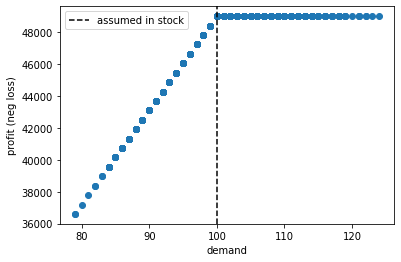

In [10]:
# Evaluating our profit over the historical demands
plt.scatter(demand_samples, -loss(in_stock=100, demand=demand_samples, buy_price=10))
plt.xlabel('demand'); plt.ylabel('profit (neg loss)'); plt.axvline(100, c='k', ls='--', label='assumed in stock');
plt.legend();

## Estimating the yield with a Bayesian Model

In [12]:
with pm.Model() as model:
    # Priors on alpha and beta parameters for each supplier
    α = pm.HalfNormal('α', sd=10., shape=3)
    β = pm.HalfNormal('β', sd=10., shape=3)
    
    # Different likelihood for every supplier because we have different
    # number of data points
    for i, d in enumerate(data):
        pm.Beta(f'supplier_yield_obs_{i}', 
            alpha=α[i], beta=β[i],
            observed=d)
    
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 659.93draws/s]


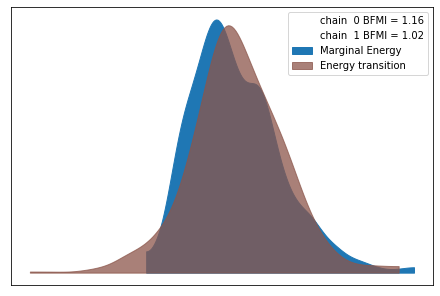

In [13]:
# make sure convergence looks good
az.plot_energy(trace);

## Generate Possible future scenarios

In [15]:
with model:
    post_pred = pm.sample_posterior_predictive(trace, 1000)

100%|██████████| 1000/1000 [00:03<00:00, 331.22it/s]


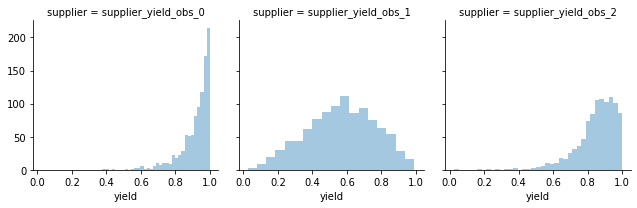

In [16]:
supplier_yield_post_pred = pd.DataFrame({k: v[:, 1] for k, v in post_pred.items()})
data_tidy = supplier_yield_post_pred.unstack().to_frame('yield')
data_tidy.index = data_tidy.index.set_names(['supplier', 'obs'])
g = sns.FacetGrid(data=data_tidy.reset_index().dropna(), col='supplier')
g.map(sns.distplot, 'yield', kde=False);

In [17]:
def calc_yield_and_price(orders, 
                         supplier_yield=np.array([.9, .5, .8]),
                         prices=PRICES
                        ):
    orders = np.asarray(orders)
    
    full_yield = np.sum(supplier_yield * orders)
    price_per_item = np.sum(orders * prices) / np.sum(orders)
    
    return full_yield, price_per_item

calc_yield_and_price([100, 60, 60])

(168.0, 160.0)

## Bayesian Decision Making

In [18]:
def objective(orders, supplier_yield=supplier_yield_post_pred,
              demand_samples=demand_samples, max_order_size=MAX_ORDER_SIZE):
    orders = np.asarray(orders)
    losses = []
    
    # Negative orders are impossible, indicated by np.inf
    if np.any(orders < 0):
        return np.inf
    # Ordering more than the supplier can ship is also impossible
    if np.any(orders > MAX_ORDER_SIZE):
        return np.inf
    
    # Iterate over post pred samples provided in supplier_yield
    for i, supplier_yield_sample in supplier_yield.iterrows():
        full_yield, price_per_item = calc_yield_and_price(
            orders,
            supplier_yield=supplier_yield_sample
        )
        
        # evaluate loss over each sample with one sample from the demand distribution
        loss_i = loss(full_yield, demand_samples[i], price_per_item)
        
        losses.append(loss_i)
        
    return np.asarray(losses)

In [19]:
from scipy import optimize

# parameters for the optimization, we're just including the max order sizes as bounds
bounds = [(0, max_order) for max_order in MAX_ORDER_SIZE]
starting_value = [50., 50., 50.]

# minimize the expected loss under all possible scenarios
opt_stoch = optimize.minimize(lambda *args: np.mean(objective(*args)), 
                              starting_value, 
                              bounds=bounds)

print('Optimal order amount from every supplier = {}'.format(np.ceil(opt_stoch.x)))

print('Total order amount from all suppliers = {}'.format(np.ceil(np.sum(opt_stoch.x))))

Optimal order amount from every supplier = [ 0. 80. 82.]
Total order amount from all suppliers = 162.0


## Model Evaluation

In [20]:
# Compare the Bayesian approach to a naive method, this is the mean

supplier_yield_mean = pd.DataFrame([np.mean(d) for d in data]).T
supplier_yield_mean

,0,1,2
0,0.918735,0.558903,0.896244


In [21]:
opt_non_stoch = optimize.minimize(lambda *args: objective(*args, 
                                                          supplier_yield=supplier_yield_mean, 
                                                          demand_samples=[100]), 
                                  starting_value, 
                                  bounds=bounds)

print('Optimal order amount from every supplier = {}'.format(np.ceil(opt_non_stoch.x)))

print('Total order amount from all suppliers = {}'.format(np.ceil(np.sum(opt_non_stoch.x))))

Optimal order amount from every supplier = [42. 46. 42.]
Total order amount from all suppliers = 128.0


In [22]:
# it is very different from the result of the Bayesian model. Let us generat dummy data and evaluate the profits.

np.random.seed(123)
data_new = []
for supplier_yield, supplier_yield_sd, n_obs in zip(SUPPLIER_YIELD, SUPPLIER_YIELD_SD, N_OBS):
    data_new.append(pm.Beta.dist(mu=supplier_yield, sd=supplier_yield_sd, shape=1000).random())
data_new = pd.DataFrame(data_new).T
data_new.head().add_prefix("Supplier ")

,Supplier 0,Supplier 1,Supplier 2
0,0.880298,0.752686,0.997934
1,0.698046,0.307304,0.971085
2,0.676807,0.534287,0.891209
3,0.943773,0.666368,0.975907
4,0.911538,0.457898,0.556483


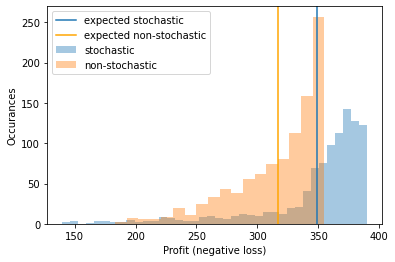

In [23]:
neg_loss_stoch = -objective(opt_stoch.x, supplier_yield=data_new) / demand_samples
neg_loss_non_stoch = -objective(opt_non_stoch.x, supplier_yield=data_new) / demand_samples
sns.distplot(neg_loss_stoch, label='stochastic', kde=False)
plt.axvline(np.mean(neg_loss_stoch), label='expected stochastic')
sns.distplot(neg_loss_non_stoch, label='non-stochastic', kde=False)
plt.axvline(np.mean(neg_loss_non_stoch), color='orange', label='expected non-stochastic')
plt.legend(); plt.xlabel('Profit (negative loss)'); plt.ylabel('Occurances');

In [24]:
print('Expected profit of Bayesian model = %.2f BTC' % np.mean(neg_loss_stoch))

Expected profit of Bayesian model = 348.73 BTC


In [25]:
print('Expected profit of naive model = %.2f BTC' % np.mean(neg_loss_non_stoch))

Expected profit of naive model = 317.01 BTC
